<a href="https://colab.research.google.com/github/c-s-ale/MachineLearningProjects/blob/Kaggle-Competitions/Chris%20Alexiuk%20-%20%20Independent%20Kaggle%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading/Preprocessing
---

The first thing to do is load up all that data, and convert it into something workable!

I'm using a dataset pulled from Kaggle.com for this project, it can be found here: https://www.kaggle.com/c/histopathologic-cancer-detection/data 

My project notes can be found here: https://docs.google.com/document/d/1SjDwPNRkjq7bx6mXK_XDXmLPam15xlhff7ezya5ch1c/edit



In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
base_data_path = '/data/'

In [3]:
train_data_path = base_data_path + 'train/'
train_labels_df = pd.read_csv(base_data_path + 'train_labels.csv')
train_labels_df['filename'] = train_labels_df.id + '.tif'
print(train_labels_df.shape)

(220025, 3)


Next, we check to see if the classes are balanced within the dataset. Here a 0 indicates a non-malignant case, and a 1 indicates a malignant case.

In [4]:
value_counts = train_labels_df['label'].value_counts()
samples = train_labels_df.shape[0]

malignant_percent = round((value_counts[1] / samples) * 100, 2)
nonmalignant_percent = round((value_counts[0] / samples) * 100, 2)

if malignant_percent > nonmalignant_percent:
  diff = malignant_percent - nonmalignant_percent
else:
  diff = nonmalignant_percent - malignant_percent

print(f"~{malignant_percent}% of the {samples} samples are malignant.")
print(f"~{nonmalignant_percent}% of the {samples} samples are non-malignant.")
print(f"There is a imbalance of {diff}% between the two classes.")

~40.5% of the 220025 samples are malignant.
~59.5% of the 220025 samples are non-malignant.
There is a imbalance of 19.0% between the two classes.


# Visualizing Some of the Data

Modifying some code I found online, let's take a peek at some of the data:

In [5]:
#helper function for opening the images
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

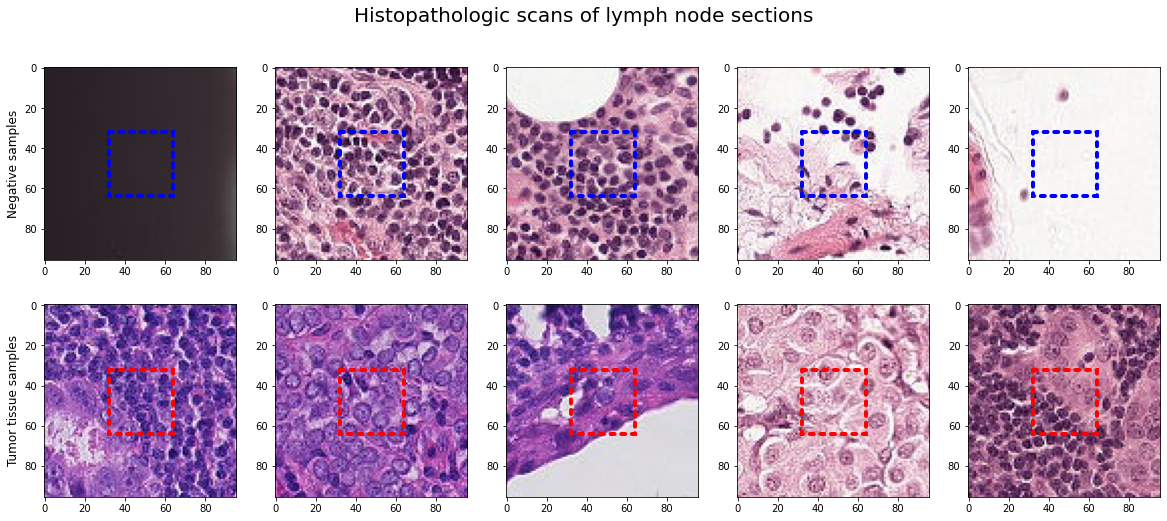

In [6]:
from sklearn.utils import shuffle
import matplotlib.patches as patches

shuffled_images = shuffle(train_labels_df, random_state=42)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_images[shuffled_images['label'] == 0]['id'][:5]):
    path = os.path.join(train_data_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_images[shuffled_images['label'] == 1]['id'][:5]):
    path = os.path.join(train_data_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

Already, I can spot a few problems with the data! Some slides seem to contain very little information. If we look at the first negative sample, we can see it's mostly just a dark blur. Similarly, the last negative sample is mostly just bright white. 

# Feature Engineering
In terms of feature selection, I believe we need all the features here - since they represent pixels in the image. However, not all of each image is expressly required since we're only worrying about a 32x32 region in the center of each image.

In [7]:
ORIGINAL_SIZE = 96
CROPPED_SIZE = 50

In [8]:
def image_crop(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])

    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROPPED_SIZE) // 2
    end_crop = start_crop + CROPPED_SIZE
    rgb_img = rgb_img[(start_crop):(end_crop), (start_crop):(end_crop)] / 255
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

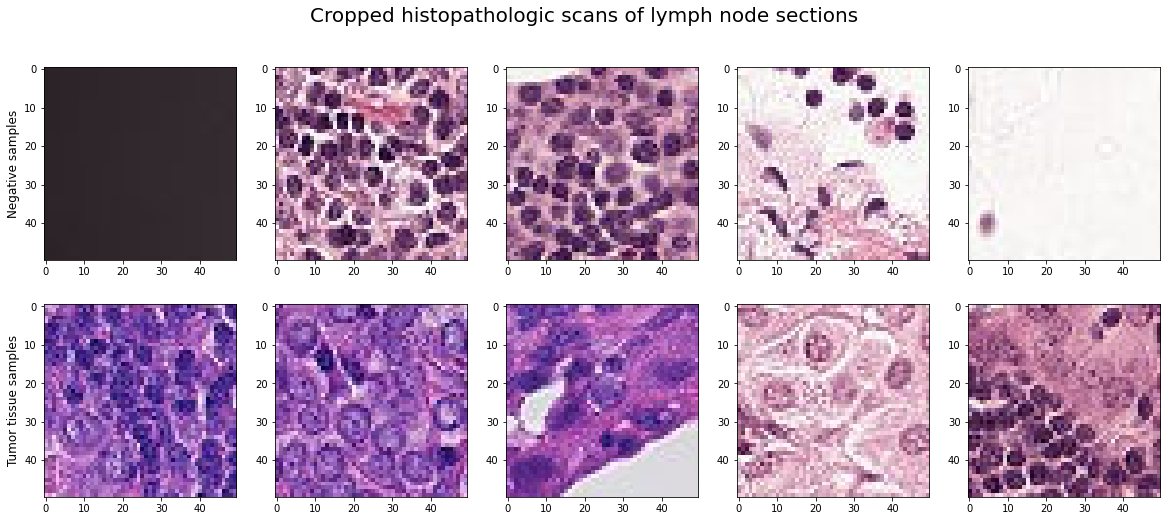

In [9]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_images[shuffled_images['label'] == 0]['id'][:5]):
    path = os.path.join(train_data_path, idx)
    ax[0,i].imshow(image_crop(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_images[shuffled_images['label'] == 1]['id'][:5]):
    path = os.path.join(train_data_path, idx)
    ax[1,i].imshow(image_crop(path + '.tif'))
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

Let's check to see if any pictures are too bright, or too dark!

Code followed from Kaggle Notebook. This cell takes a long time to run, it's only a marginal increase of accuracy, I've include a pickle that includes both too_bright_idx and too_dark_idx in order to shortcut running this step.

In [10]:
from tqdm.notebook import tqdm
def locate_bright_and_dark():
    dark_th = 10 / 255      # If no pixel reaches this threshold, image is considered too dark
    bright_th = 245 / 255   # If no pixel is under this threshold, image is considerd too bright
    too_dark_idx = []
    too_bright_idx = []

    x_tot = np.zeros(3)
    x2_tot = np.zeros(3)  
    counted_ones = 0
    for i, idx in tqdm(enumerate(shuffled_images['id']), '220025 samples in total'):
        path = os.path.join(train_data_path, idx)
        imagearray = image_crop(path + '.tif').reshape(-1,3)
        if(imagearray.max() < dark_th):
            too_dark_idx.append(idx)
            continue
        if(imagearray.min() > bright_th):
            too_bright_idx.append(idx)
            continue
        x_tot += imagearray.mean(axis=0)
        x2_tot += (imagearray**2).mean(axis=0)
        counted_ones += 1
        
    channel_avr = x_tot/counted_ones
    channel_std = np.sqrt(x2_tot/counted_ones - channel_avr**2)
    channel_avr,channel_std
    return too_dark_idx, too_bright_idx

In [11]:
import pickle

def save_outliers(obj, name):
    with open('outliers/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
    f.close()

def open_outliers(name):
    with open('outliers/' + name + '.pkl', 'rb') as f:
        obj = pickle.load(f)
    f.close()
    return obj

In [12]:
# Uncomment to check the entire dataset for bright and dark images. Runtime ~1h30min
#too_dark_idx, too_bright_idx = locate_bright_and_dark()#save_outliers(too_dark_idx, 'too_dark_idx')
#save_outliers(too_bright_idx, 'too_bright_idx')
#save_outliers(too_dark_idx, 'too_dark_idx')

too_dark_idx = open_outliers('too_dark_idx')
too_bright_idx = open_outliers('too_bright_idx')

Text(0, 0.5, 'Too Bright')

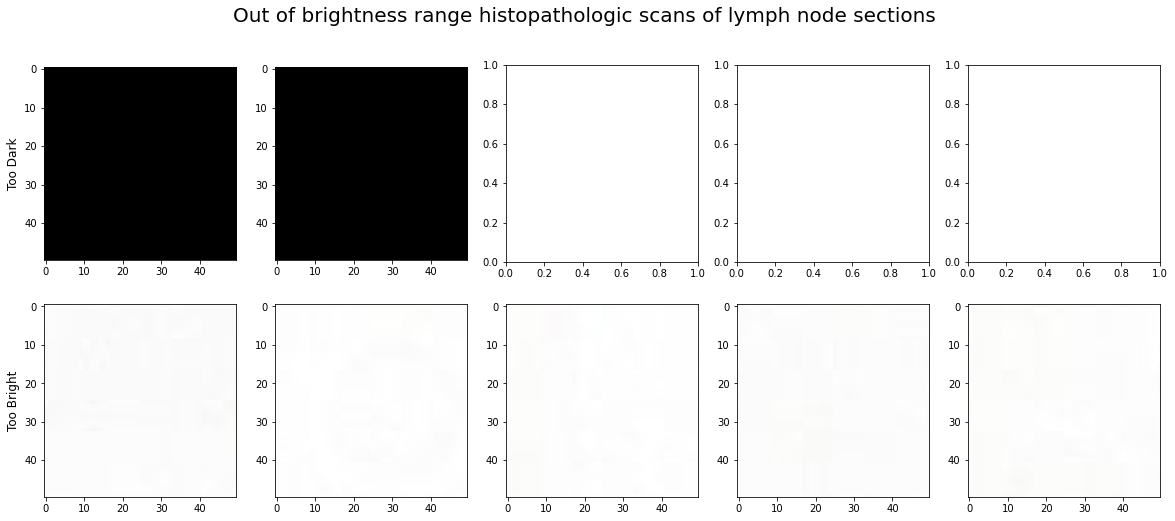

In [13]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Out of brightness range histopathologic scans of lymph node sections',fontsize=20)

for i, id in enumerate(too_dark_idx):
    path = os.path.join(train_data_path, id)
    ax[0,i].imshow(image_crop(path + '.tif'))
ax[0,0].set_ylabel('Too Dark', size='large')

for i, id in enumerate(too_bright_idx[:5]):
    path = os.path.join(train_data_path, id)
    ax[1,i].imshow(image_crop(path + '.tif'))
ax[1,0].set_ylabel('Too Bright', size='large')

There doesn't seem to be a lot of information to be gathered from these photos, so I am going to go ahead and drop them from the test.

Interesting fact, at oblique angles to the monitor - you can "kind of" see the bright patches. I am still omitting them from training, however.

In [14]:
def filter_rows_by_values(df, col, values):
  return df[~df[col].isin(values)]

train_labels_df = filter_rows_by_values(train_labels_df, 'id', too_dark_idx)
train_labels_df = filter_rows_by_values(train_labels_df, 'id', too_bright_idx)
print(train_labels_df.shape) 

(219958, 3)


# Data Selection / Sampling:

Now, I'm going to cut the original data down quite considerably for modelling!

In [15]:
from sklearn.model_selection import train_test_split

sample, ignore = train_test_split(train_labels_df, test_size=0.99, random_state=42, stratify=train_labels_df.label)
print(sample.shape)

(2199, 3)


Then, convert the samples into their training formats:

In [16]:
def create_training_set(label_id_df, image_directory, samples=None):
  if samples is None:
    samples = label_id_df.shape[0]
  
  image_data_list = [None] * samples
  label_list = [None] * samples
  
  current_sample = 0
  for row in label_id_df.itertuples(index=False):
    current_sample += 1
    file_path = image_directory + row[0] + '.tif'
    cropped_image = image_crop(file_path)
    cropped_image_array = np.array(cropped_image).flatten()
    label_list[current_sample-1] = row[1]
    image_data_list[current_sample-1] = cropped_image_array
    if current_sample % 1000 == 0:
      print(current_sample)
    if current_sample == samples:
      break

  return image_data_list, label_list

In [17]:
X, y = create_training_set(sample, train_data_path)
clear_output()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [19]:
print(f"There are {len(X_train)} sample in X_train. Each sample has {len(X_train[0])} features.")

There are 1979 sample in X_train. Each sample has 7500 features.


In [20]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
train_dict = dict(zip(unique_train, counts_train))
train_proportion = (train_dict[1] / len(y_train)) * 100

print(f"The proportion of malignant tumours in the training set is: {train_proportion:.2f}%")

unique_test, counts_test = np.unique(y_test, return_counts=True)
test_dict = dict(zip(unique_test, counts_test))
test_proportion = (test_dict[1] / len(y_test)) * 100

print(f"The proportion of malignant tumours in the test set is: {test_proportion:.2f}%")

The proportion of malignant tumours in the training set is: 40.53%
The proportion of malignant tumours in the test set is: 40.45%


## Model Building and Training

In the following...many cells, we'll be taking a look at a lot of various models and trying to find the most performative from the bunch. I'll be using techniques we've learned through out various weeks at the Machine Learning Engineering program FourthBrain!

So far we've covered: 

1. Linear Regression
2. Basic Supervised Learning
3. Supervised Classification
4. Basic Unsupervised Learning (not as useful for this dataset, though perhaps could be used to visualize the data)
5. AutoML through TPOT

### Helper Functions

In [21]:
scores_df = pd.DataFrame(columns=['Model Name', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC Score'])
def add_model_to_score_df(scores_df, name, score, rec, prec, f1, roc_auc):
  scores_df.loc[len(scores_df)] = [name, score, rec, prec, f1, roc_auc]
  return

In [22]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(X_test, y_true, model):
  y_pred = model.predict_proba(X_test)[:,1]
  fpr, tpr, _ = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 2)))
  plt.legend(loc='lower right')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  return roc_auc

def report_model(X_test, prediction, true, model, model_name, scores_df=None):
  cm = metrics.confusion_matrix(true, prediction)
  score = model.score(X_test, y_test) * 100
  recall = metrics.recall_score(true, prediction) * 100
  precision = metrics.precision_score(true, prediction) * 100
  f1_score = metrics.f1_score(true, prediction) * 100
  print_out = f"{model_name} Metrics:\nAccuracy: {score:.2f}%"
  print_out += f"\nRecall: {recall:.2f}%\nPrecision: {precision:.2f}%\nF1: {f1_score:.2f}%\n"
  roc_auc = plot_roc_curve(X_test, true, model)
  print(print_out)
  if scores_df is not None:
    add_model_to_score_df(scores_df, model_name, score, recall, precision, f1_score, roc_auc)
    return scores_df
  return 


### Logistic Regression

Not a lot to say about this one, fit the model, carry on.

In [23]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(solver='lbfgs', max_iter=5000, random_state=42).fit(X_train, y_train)
log_predictions = log_clf.predict(X_test)

#Alt-Names for Notebook:
#Bird Bot 2.0: Cancer Culture Strikes Back

Logistic Regression Metrics:
Accuracy: 61.82%
Recall: 50.56%
Precision: 52.94%
F1: 51.72%



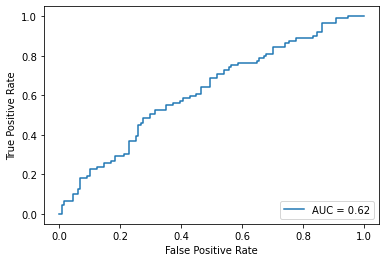

In [24]:
scores_df = report_model(X_test, log_predictions, y_test, log_clf, "Logistic Regression", scores_df)

#Decision Tree Based Models

My intuition here is that the RandomForest with class_weights will be the most performative of the bunch, and hopefully perform better than the Logistic Regression model - which, to be frank, sucked.

First up, I am naively iterating over max_depth to try and find the best max_depth for the unweighted RandomForestClassifier. I'm sure there is a better way, I will find it and implement it soon!

C:\Users\scott\anaconda3\envs\fourthbrain_tf_2\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RandomForestClassifier - (Max Depth: 1) Metrics:
Accuracy: 59.55%
Recall: 0.00%
Precision: 0.00%
F1: 0.00%

RandomForestClassifier - (Max Depth: 2) Metrics:
Accuracy: 69.09%
Recall: 26.97%
Precision: 88.89%
F1: 41.38%

RandomForestClassifier - (Max Depth: 3) Metrics:
Accuracy: 75.45%
Recall: 48.31%
Precision: 84.31%
F1: 61.43%

RandomForestClassifier - (Max Depth: 4) Metrics:
Accuracy: 78.18%
Recall: 61.80%
Precision: 79.71%
F1: 69.62%

RandomForestClassifier - (Max Depth: 5) Metrics:
Accuracy: 80.45%
Recall: 66.29%
Precision: 81.94%
F1: 73.29%

RandomForestClassifier - (Max Depth: 6) Metrics:
Accuracy: 78.64%
Recall: 64.04%
Precision: 79.17%
F1: 70.81%

RandomForestClassifier - (Max Depth: 7) Metrics:
Accuracy: 76.36%
Recall: 65.17%
Precision: 73.42%
F1: 69.05%

RandomForestClassifier - (Max Depth: 8) Metrics:
Accuracy: 79.09%
Recall: 71.91%
Precision: 75.29%
F1: 73.56%

RandomForestClassifier - (Max Depth: 9) Metrics:
Accuracy: 77.73%
Recall: 66.29%
Precision: 75.64%
F1: 70.66%

Rand

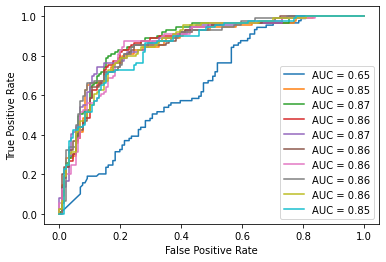

In [25]:
from sklearn.ensemble import RandomForestClassifier

for i in range(0, 10):
  max_depth = i+1
  rf_i_clf = RandomForestClassifier(max_depth=max_depth, random_state=42).fit(X_train, y_train)
  rf_i_predictions = rf_i_clf.predict(X_test)
  report_model(X_test, rf_i_predictions, y_test, rf_i_clf, f"RandomForestClassifier - (Max Depth: {max_depth})")

What these numbers tell me is that, while max_depth=10 had a decent accuracy, for malignancy detection, I feel like max_depth=8 is the best trade-off: high recall, decent accuracy!

In [26]:
rf_clf = RandomForestClassifier(max_depth=8, random_state=42).fit(X_train, y_train)
rf_predictions = rf_clf.predict(X_test)

RandomForestClassifier Metrics:
Accuracy: 79.09%
Recall: 71.91%
Precision: 75.29%
F1: 73.56%



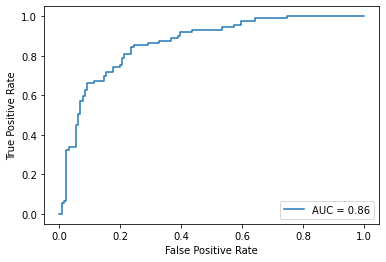

In [27]:
scores_df = report_model(X_test, rf_predictions, y_test, rf_clf,  "RandomForestClassifier", scores_df)

It's time to naively iterate through max_depths again! This time featuring: class_weight = 'balanced'. We know from our initial dataset, as well as looking at the train/test labels that our dataset is imbalanced...is this the parameter needed to bring this model to an acceptable level?!

RandomForestClassifier - Class Balanced (Max Depth: 1) Metrics:
Accuracy: 59.55%
Recall: 85.39%
Precision: 50.00%
F1: 63.07%

RandomForestClassifier - Class Balanced (Max Depth: 2) Metrics:
Accuracy: 69.55%
Recall: 93.26%
Precision: 57.64%
F1: 71.24%

RandomForestClassifier - Class Balanced (Max Depth: 3) Metrics:
Accuracy: 77.27%
Recall: 94.38%
Precision: 65.12%
F1: 77.06%

RandomForestClassifier - Class Balanced (Max Depth: 4) Metrics:
Accuracy: 77.73%
Recall: 88.76%
Precision: 66.95%
F1: 76.33%

RandomForestClassifier - Class Balanced (Max Depth: 5) Metrics:
Accuracy: 77.27%
Recall: 86.52%
Precision: 66.96%
F1: 75.49%

RandomForestClassifier - Class Balanced (Max Depth: 6) Metrics:
Accuracy: 78.64%
Recall: 83.15%
Precision: 69.81%
F1: 75.90%

RandomForestClassifier - Class Balanced (Max Depth: 7) Metrics:
Accuracy: 77.73%
Recall: 84.27%
Precision: 68.18%
F1: 75.38%

RandomForestClassifier - Class Balanced (Max Depth: 8) Metrics:
Accuracy: 80.91%
Recall: 83.15%
Precision: 73.27%
F1: 

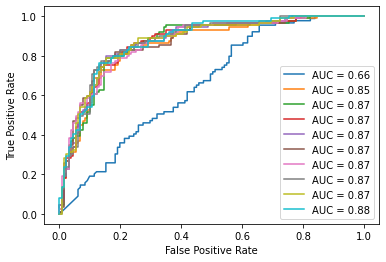

In [28]:
for i in range(0, 10):
  max_depth = i+1
  rf_i_clf = RandomForestClassifier(max_depth=max_depth, class_weight='balanced', random_state=42).fit(X_train, y_train)
  rf_i_predictions = rf_i_clf.predict(X_test)
  report_model(X_test, rf_i_predictions, y_test, rf_i_clf, f"RandomForestClassifier - Class Balanced (Max Depth: {max_depth})")

No, as it turns out. 

However, there is some good news for sure! This run from 1-10 max_depth gives us the most performative model **so far** at max_depth=9, with a pretty decent 

* Accuracy: 81.82% 
* Recall: ~82.02%!

In [29]:
rf_bc_clf = RandomForestClassifier(max_depth=9, class_weight='balanced', random_state=42).fit(X_train, y_train)
rf_bc_predictions = rf_bc_clf.predict(X_test)

RandomForestClassifier - Class Balanced Metrics:
Accuracy: 79.09%
Recall: 80.90%
Precision: 71.29%
F1: 75.79%



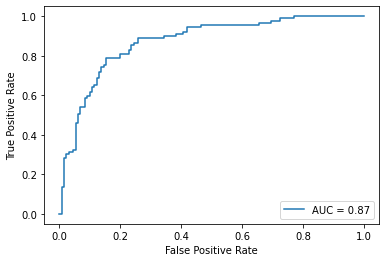

In [30]:
scores_df = report_model(X_test, rf_bc_predictions, y_test, rf_bc_clf, "RandomForestClassifier - Class Balanced", scores_df)

# Support Vector Machine

Another model to try is the SVM. Using GridSearchCV (learned about in Week 2) the idea is simple: Find the best parameters, and then fit a model using them. 

Continuing the theme of only really caring about Recall, I'm going to attempt to find the best parameters scored on Recall, as well as AUC - which is another strong metric to guage model...strength, as I understand it.

Due to the size of the dataset, I had to use a BaggingClassifier in order to 
keep the gridsearch time to a "reasonable" ~10min. Technically, this employs
strategies we learned in Week 2.

Considering how large the dataset is, it feels like SVM is not a realistic 
solution when it comes to computational costs.

In [31]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

n_estimators=10
param_grid = {'base_estimator__C' : [0.1, 1, 10], 'base_estimator__gamma' : [0.0001, 0.001, 0.01]}
svc_bagged = BaggingClassifier(SVC(class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
svc_clf_roc = GridSearchCV(svc_bagged, param_grid=param_grid, scoring='roc_auc')
svc_clf_rec = GridSearchCV(svc_bagged, param_grid=param_grid, scoring='recall')

Uncomment the below code to run the GridSearch for yourself!

In [32]:
#svc_clf_roc.fit(X_train, y_train)
#svc_clf_rec.fit(X_train, y_train)
#clear_output()
#print(f"The best params for ROC scoring: {svc_clf_roc.best_params_}")
#print(f"The best params for Recall scoring: {svc_clf_rec.best_params_}")

Now that I have the "best" parameters for what I think are the things we want to optimize, I run the models and get those sweet metrics.

In [33]:
svc_best_roc_clf = BaggingClassifier(SVC(C=10, gamma=0.01, kernel='rbf', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators, verbose=2).fit(X_train, y_train)
svc_best_roc_predictions = svc_best_roc_clf.predict(X_test)

svc_best_rec_clf = BaggingClassifier(SVC(C=1, gamma=0.001, kernel='rbf', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators, verbose=2).fit(X_train, y_train)
svc_best_rec_predictions = svc_best_rec_clf.predict(X_test)
clear_output()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVM - Best Params for ROC Metrics:
Accuracy: 75.45%
Recall: 47.19%
Precision: 85.71%
F1: 60.87%



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVM - Best Params for Recall Metrics:
Accuracy: 82.73%
Recall: 77.53%
Precision: 79.31%
F1: 78.41%



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


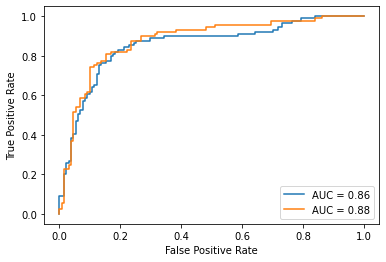

In [34]:
scores_df = report_model(X_test, svc_best_roc_predictions, y_test, svc_best_roc_clf, "SVM - Best Params for ROC", scores_df)
scores_df = report_model(X_test, svc_best_rec_predictions, y_test, svc_best_rec_clf, "SVM - Best Params for Recall", scores_df)

#Model Scoring and Discussion

That's it for up to Week 2! I'm going to take this chance to discuss some of the findings and try and identify the best model, so far!

In [35]:
def model_scores(scores_df, sort_string):
  display(scores_df.sort_values(by=sort_string, ascending=False))

In [36]:
model_scores(scores_df, 'AUC Score')

,Model Name,Accuracy,Recall,Precision,F1 Score,AUC Score
4,SVM - Best Params for Recall,82.727273,77.528090,79.310345,78.409091,0.877948
2,RandomForestClassifier - Class Balanced,79.090909,80.898876,71.287129,75.789474,0.871172
1,RandomForestClassifier,79.090909,71.910112,75.294118,73.563218,0.864139
3,SVM - Best Params for ROC,75.454545,47.191011,85.714286,60.869565,0.856077
0,Logistic Regression,61.818182,50.561798,52.941176,51.724138,0.618921


From the above, my intuition is that the best model (SO FAR) for this task, and this data (using the sampling split from above) is:

* RandomForestClassifier
* max_depth=9
* class_weights='balanced'

The model performs semi-reasonably on the test data, achieving metrics:

* Accuracy: 81.82%
* Recall: 82.02%
* Precision: 75.26%
* F1 Score: 78.49%
* AUC: 0.8687

My thought process is since the model is trying to identify malignancy, we want to optimize fairly heavily for recall. 



## Using TPOT to obtain a better model!

In [37]:
X_train = np.array(X_train)
y_train = np.array(y_train)

Comment out the pipeline_optimizer lines to run the cell yourself!

In [38]:
from tpot import TPOTClassifier

pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5, n_jobs=-3,
                                    random_state=42, verbosity=2, scoring='roc_auc')

## Uncomment below to run the TPOT optimization!
#pipeline_optimizer.fit(X_train, y_train)
#pipeline_optimizer.export('tpot_exported_pipeline.py')

In [39]:
from sklearn.ensemble import ExtraTreesClassifier

extra_tree_model = ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.3, min_samples_leaf=3, min_samples_split=9, n_estimators=100).fit(X_train, y_train)
extra_tree_preds = extra_tree_model.predict(X_test)

Extra Trees Metrics:
Accuracy: 80.00%
Recall: 65.17%
Precision: 81.69%
F1: 72.50%



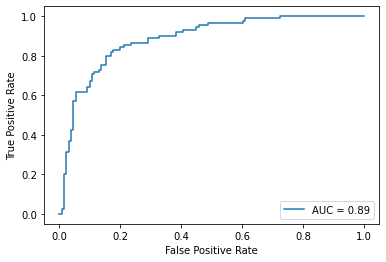

In [40]:
scores_df = report_model(X_test, extra_tree_preds, y_test, extra_tree_model, "Extra Trees", scores_df)

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=20, p=2, weights="uniform")

knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

KNN Metrics:
Accuracy: 58.18%
Recall: 82.02%
Precision: 48.99%
F1: 61.34%



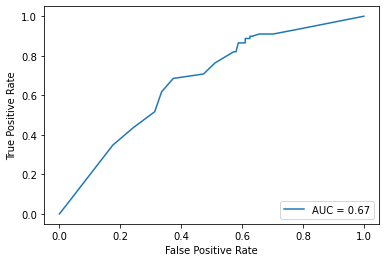

In [42]:
scores_df = report_model(X_test, knn_preds, y_test, knn_model, "KNN", scores_df)

In [43]:
model_scores(scores_df, 'AUC Score')

,Model Name,Accuracy,Recall,Precision,F1 Score,AUC Score
5,Extra Trees,80.000000,65.168539,81.690141,72.500000,0.886011
4,SVM - Best Params for Recall,82.727273,77.528090,79.310345,78.409091,0.877948
2,RandomForestClassifier - Class Balanced,79.090909,80.898876,71.287129,75.789474,0.871172
1,RandomForestClassifier,79.090909,71.910112,75.294118,73.563218,0.864139
3,SVM - Best Params for ROC,75.454545,47.191011,85.714286,60.869565,0.856077
6,KNN,58.181818,82.022472,48.993289,61.344538,0.673385
0,Logistic Regression,61.818182,50.561798,52.941176,51.724138,0.618921


## Generate Predictions

Current TODO

In [44]:
test_df = pd.read_csv(base_data_path + 'sample_submission.csv')
test_data_path = base_data_path + '/test/'
print(test_df.shape[0])

57458
